<a href="https://colab.research.google.com/github/coutosergio/coutosergio/blob/main/TCC_Sergio_Couto_CarPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, LinAlgError
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV

In [2]:
dados = pd.read_csv('/content/CarPrice_Assignment.csv')


# teste para adiconar ao repositorio girhub
dados = dados.drop('car_ID', axis =1)

marca = dados.pop('CarName').str.split().str[0]
dados.insert(3, 'Company', marca)
dados['Company'] = dados.Company.str.lower()


def substituir(a,b):
    dados.Company.replace(a,b,inplace=True)
substituir('vw','volkswagen')
substituir('maxda','mazda')
substituir('vokswagen','volkswagen')
substituir('porcshce','porsche')
substituir('toyouta','toyota')



dados['symboling'] = dados['symboling'].astype('object')

#seleciona os apenas os dados categóritos
dados_categorico = dados.select_dtypes(include=['object'])

#exclui os dados categóricos do dataframe original
dados = dados.drop(list(dados_categorico.columns), axis=1)

#aplica a função getdummies excluindo o primeiro tipo de cada uma das covariáveis categóricas
dados_dummies = pd.get_dummies(dados_categorico, drop_first=True)
#define como 1 ou 0 ao invés de True ou False
dados_dummies = dados_dummies.astype(int)

#Une os dados numéricos e com os dados dummies
dados = pd.concat([dados, dados_dummies], axis=1)

#aplica o logaritmo nas colunas "price", "peakrpm" e "curbweight"
dados['price'] = np.log(dados['price'])
dados['peakrpm'] = np.log(dados['peakrpm'])
dados['curbweight'] = np.log(dados['curbweight'])

######################### SEPARA O CONJUNTO DE DADOS ENTRE TREINO E TESTE E APLICA A RIDGE-CV #########################

#separa o conjunto de treino e de teste
train, test = train_test_split(dados, test_size = 0.3, random_state = 31)

#separa entre x e y de treino e x e y de teste
y_train = train['price']
x_train = train.drop('price', axis = 1)
y_test = test['price']
x_test = test.drop('price', axis = 1)


#padroniza os dados numéricos de x de treino e teste com base nos dados numéricos de x de treino
scaler = StandardScaler()
x_train[['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg']]=scaler.fit_transform(x_train[['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg']])

x_test[['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg']]=scaler.transform(x_test[['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg']])

#padroniza os y de treino e de teste com base no y de treino
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean)/y_train_std
y_test = (y_test - y_train_mean)/y_train_std

#cria o vetor de lambdas
alphas = np.linspace(0.001,20,10000)

#aplica a regressão ridge pronta e a CV para o vetor de lambdas com base no x e y de treino e retorna o melhor lambda
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error',fit_intercept=True)
ridge_cv.fit(x_train, y_train)
best_alpha_cv = ridge_cv.alpha_

#define os betas da CV como "estimadores"
estimadores = ridge_cv.coef_
estimadores = np.insert(estimadores, 0, ridge_cv.intercept_)
#define o melhor lambda
alpha = best_alpha_cv

######################### PREPARA OS DADOS PARA APLICAR A RIDGE "MANUALMENTE" #########################

#insere uma coluna de "1" x de treino e de teste
x_train.insert(loc = 0, column='Intercept', value = 1)
x_test.insert(loc = 0, column = 'Intercept', value = 1)
#cria a matriz identidade
I = np.identity(x_train.shape[1])
#Modifica I para que o termo a11 seja 0
I[0, 0] = 0

#cria uma lista vazia para os betas, pro erro absoluto médio, r^2 e erro quadrático médio
erros = []
r2 = []
erro_squared = []
betas_ridge = []
pred = []

#cria uma lista com o nome das colunas numéricas
nomes_colunas = x_train.columns



#loop para calcular ridge para cada um dos labdas
for i in alphas:
  beta_ridge = np.dot(np.dot(inv(np.dot(x_train.T,x_train) + i*I),x_train.T),y_train)
  betas_ridge.append(beta_ridge)
  r2.append(r2_score(y_test,x_test @ beta_ridge))
  erro_squared.append(mean_squared_error(y_test,x_test @ beta_ridge))
  erros.append(mean_absolute_error(y_test,x_test @ beta_ridge))

#calcula manualmente os estimadores com base no melhor lambda determinado pela CV
beta_ridge_A = np.dot(np.dot(inv(np.dot(x_train.T, x_train) + alpha * I), x_train.T),y_train)

#calcula manualmente os estimadores dos mínimos quadrados ordinários
beta_mmq = np.dot(np.dot(inv(np.dot(x_train.T, x_train)), x_train.T),y_train)

#calcula manualmente os estimadores dos mínimos quadrados ordinários usando a pseudo-inversa
beta_mmq_pi = np.dot(np.dot(np.linalg.pinv(np.dot(x_train.T, x_train),rcond = 0), x_train.T),y_train)


from sklearn.linear_model import LinearRegression

#cria o modelo linear
mmq_linear = LinearRegression(fit_intercept=False)
'''
#treina o modelo
mmq_linear.fit(x_train, y_train)
beta_mmq = mmq_linear.coef_
#erro_mmq = mmq_betas - beta_mmq
#calcula a diferença entre o calculo da biblioteca pronta e o manual
meu_erro = beta_ridge_A - estimadores
'''


#calcula os valores previstos pela ridge
prev_treino = x_train @ beta_ridge_A
prev_teste = x_test @ beta_ridge_A
#calcula os valores previstos pelo MMQ-PI
prev_mmq_pi_treino = x_train @ beta_mmq_pi
prev_mmq_pi_teste = x_test @ beta_mmq_pi
#calcula os valores previstos pelo MMQ
prev_mmq_treino = x_train @ beta_mmq
prev_mmq_teste = x_test @ beta_mmq


#calcula os resíduos da ridge
res_treino = y_train - prev_treino
res_teste = y_test - prev_teste
#calcula dos residuos do MMQ-PI
res_mmq_pi_treino = y_train - prev_mmq_pi_treino
res_mmq_pi_teste = y_test - prev_mmq_pi_teste
#calcula dos residuos do MMQ
res_mmq_treino = y_train - prev_mmq_treino
res_mmq_teste = y_test - prev_mmq_teste

'''
y_test = y_test + y_train_mean
prev_treino = prev_treino + y_train_mean
prev_teste = prev_teste + y_train_mean
prev_mmq_pi_treino = prev_mmq_pi_treino + y_train_mean
prev_mmq_pi_teste = prev_mmq_pi_teste + y_train_mean
prev_mmq_treino = prev_mmq_treino + y_train_mean
prev_mmq_teste = prev_mmq_teste + y_train_mean


prev_test = np.exp(prev_test)
prev_mmq_test = np.exp(prev_mmq_test)
prev_mmq_manual_test = np.exp(prev_mmq_manual_test)
y_test = np.exp(y_test)
'''

n, p = x_train.shape


for i in res_treino:
  sigma2_ridge = np.sum(np.square(i))/(n)

for i in res_mmq_pi_treino:
  sigma2_mmq_pi = np.sum(np.square(i))/(n)

for i in res_mmq_treino:
  sigma2_mmq = np.sum(np.square(i))/(n)


#var_manual_df = pd.DataFrame(var_manual, columns = x_train.columns, index = x_train.columns)
#variancias_manual = np.diag(var_manual)

#beta_var_manual = pd.DataFrame({"beta": mmq_manual, "variance": variancias_manual}, index=x_train.columns)


var_ridge = sigma2_ridge*(np.linalg.inv(x_train.T @ x_train + alpha * I)) @ x_train.T @ x_train @ (np.linalg.inv(x_train.T @ x_train+ alpha * I))
var_mmq_pi = sigma2_mmq_pi*(np.linalg.pinv(x_train.T @ x_train,rcond = 0))
var_mmq = sigma2_mmq*(np.linalg.inv(x_train.T @ x_train))


#var_mmq_df = pd.DataFrame(var_beta_mmq, columns = x_train.columns, index = x_train.columns)
#var_beta_df = pd.DataFrame(var_beta, columns = x_train.columns, index = x_train.columns)
variancias_ridge = np.diag(var_ridge)
variancias_mmq_pi = np.diag(var_mmq_pi)
variancias_mmq = np.diag(var_mmq)


beta_var_ridge = pd.DataFrame({"beta": estimadores, "variance": variancias_ridge}, index=x_train.columns)
beta_var_ridge = beta_var_ridge.sort_values(by='beta', ascending=False)
beta_var_ridge = beta_var_ridge.reset_index()

beta_var_mmq_pi = pd.DataFrame({"beta": beta_mmq_pi, "variance": variancias_mmq_pi}, index=x_train.columns)
beta_var_mmq_pi = beta_var_mmq_pi.sort_values(by='beta', ascending=False)
beta_var_mmq_pi = beta_var_mmq_pi.reset_index()

beta_var_mmq = pd.DataFrame({"beta": beta_mmq, "variance": variancias_mmq}, index=x_train.columns)
beta_var_mmq = beta_var_mmq.sort_values(by='beta', ascending=False)
beta_var_mmq = beta_var_mmq.reset_index()


/tmp/ipython-input-2-578926261.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados.Company.replace(a,b,inplace=True)


In [ ]:
coef_names = [
    "fuelsystem_idi",
    "Company_honda",
    "fuelsystem_mfi",
    "Company_saab",
    "Company_mercury",
    "Company_nissan",
    "symboling_-1",
    "carlength",
    "fueltype_gas",
    "doornumber_two"
]

# filtra o df para manter só as linhas cujo coeficiente está na lista
df_filtrado = beta_var_mmq_pi[beta_var_mmq_pi["index"].isin(coef_names)]

# exibe o resultado
print(df_filtrado)

              index      beta      variance
6   Company_mercury  0.905427  9.761182e-05
7      Company_saab  0.790215  7.143775e-05
9    fuelsystem_idi  0.717147 -1.645409e+07
10    Company_honda  0.666331  9.089964e-05
12   Company_nissan  0.583176  6.021514e-05
27   fuelsystem_mfi  0.342933  5.898489e-05
45   doornumber_two -0.066252  1.893306e-06
47     symboling_-1 -0.081667  2.010610e-05
49        carlength -0.090384  3.146632e-06
67     fueltype_gas -0.568271 -1.645409e+07


In [3]:
alpha

np.float64(1.3150657065706568)

In [6]:
beta_var_mmq

,index,beta,variance
0,enginetype_ohcf,1.754544e+15,8.162411e+15
1,Intercept,4.459662e+02,-9.725152e+15
2,enginetype_l,3.696167e+02,-5.229476e+15
3,cylindernumber_two,2.073042e+02,-2.137855e+19
4,enginetype_ohcv,1.132791e+02,4.585635e+01
...,...,...,...
64,Company_chevrolet,-2.109880e+02,1.431232e+02
65,Company_peugeot,-3.382252e+02,-5.229476e+15
66,fueltype_gas,-4.419860e+02,-9.725152e+15
67,Company_subaru,-1.754544e+15,8.057372e+15


In [ ]:
y_train_mean,y_train_std,np.min(dados['price']),np.max(dados['price'])
#a = (np.min(dados['price'])-y_train_mean)/y_train_std
#b = (np.max(dados['price'])-y_train_mean)/y_train_std
#print(a,b)

(np.float64(9.325150925369153),
 0.49072706503160785,
 8.540519016719735,
 10.72326738402944)

In [ ]:
#x_train[['compressionratio','horsepower','curbweight','enginesize']].describe()
y_train.describe()

,price
count,1.430000e+02
mean,-2.360194e-16
std,1.000000e+00
min,-1.598917e+00
25%,-7.801371e-01
50%,-1.940061e-01
75%,7.876272e-01
max,2.656935e+00


In [ ]:
x_train[['curbweight','enginesize','wheelbase','highwaympg','carwidth', 'peakrpm','stroke','carlength','boreratio','carheight', 'citympg','horsepower','compressionratio']].describe(),x_test[['curbweight','enginesize','wheelbase','highwaympg','carwidth', 'peakrpm','stroke','carlength','boreratio','carheight', 'citympg','horsepower','compressionratio']].describe()

(         curbweight    enginesize     wheelbase    highwaympg      carwidth  \
 count  1.430000e+02  1.430000e+02  1.430000e+02  1.430000e+02  1.430000e+02   
 mean   3.794944e-15 -1.614870e-16 -8.136460e-16  2.232092e-17  2.645902e-15   
 std    1.003515e+00  1.003515e+00  1.003515e+00  1.003515e+00  1.003515e+00   
 min   -2.663555e+00 -1.685558e+00 -2.132094e+00 -2.071932e+00 -2.693456e+00   
 25%   -8.137579e-01 -7.293869e-01 -6.747932e-01 -9.296233e-01 -8.789569e-01   
 50%   -1.384692e-01 -1.184998e-01 -3.058564e-01 -7.289205e-02 -1.433492e-01   
 75%    8.689074e-01  4.392666e-01  4.873578e-01  7.838392e-01  5.432180e-01   
 max    2.582435e+00  5.352923e+00  2.959234e+00  3.211244e+00  3.191406e+00   
 
             peakrpm        stroke     carlength     boreratio     carheight  \
 count  1.430000e+02  1.430000e+02  1.430000e+02  1.430000e+02  1.430000e+02   
 mean   1.788779e-15  2.919188e-16  1.027927e-15 -1.006188e-15 -1.962688e-15   
 std    1.003515e+00  1.003515e+00  1.

In [ ]:
beta_var_mmq_pi,beta_var_ridge

(                    index      beta  variance sinal  importancia      erro
 0             Company_bmw  1.375404  0.000080   POS     1.375404  0.008951
 1         Company_porsche  1.311445  0.000082   POS     1.311445  0.009058
 2   cylindernumber_twelve  1.065935  0.000244   POS     1.065935  0.015625
 3           Company_isuzu  1.056541  0.000086   POS     1.056541  0.009275
 4            Company_audi  1.000499  0.000094   POS     1.000499  0.009689
 ..                    ...       ...       ...   ...          ...       ...
 64          carbody_sedan -0.492139  0.000016   NEG     0.492139  0.004051
 65        fuelsystem_spfi -0.534269  0.000072   NEG     0.534269  0.008476
 66        carbody_hardtop -0.556563  0.000013   NEG     0.556563  0.003643
 67      carbody_hatchback -0.586400  0.000015   NEG     0.586400  0.003907
 68           fueltype_gas -0.604826  0.000096   NEG     0.604826  0.009778
 
 [69 rows x 6 columns],
                   index      beta  variance sinal  importanci

In [ ]:
x_train['curbweight'].describe()

,curbweight
count,1.430000e+02
mean,3.794944e-15
std,1.003515e+00
min,-2.663555e+00
25%,-8.137579e-01
50%,-1.384692e-01
75%,8.689074e-01
max,2.582435e+00


In [ ]:
r2_score(y_test,prev_mmq_pi_teste)

0.9025538297425629

In [ ]:
mean_squared_error(y_test,prev_mmq_teste)

2005.0069507498192

In [ ]:
mean_squared_error(y_test,prev_mmq_pi_teste)

0.1120730983882006

In [ ]:
mean_squared_error(y_test,prev_teste)

0.09752526922110182

In [ ]:
# Calcular os valores singulares de x_train
S = np.linalg.svd(x_train, compute_uv=False)

# Número de condição = razão entre maior e menor valor singular
cond_number = S[0] / S[-1]

print("Número de condição de x_train:", cond_number)

Número de condição de x_train: 1.9535477683581926e+17


In [ ]:
diferenca = pd.merge(beta_var, beta_var_mmq, on='index', how='inner')
diferenca['diferenca'] = diferenca['beta_y']  - diferenca['beta_x']
#diferenca[['index','diferenca']]
diferenca['variance_x'] = diferenca['variance_x'].apply(lambda x: np.sqrt(x))
diferenca['variance_y'] = diferenca['variance_y'].apply(lambda x: np.sqrt(x))
diferenca

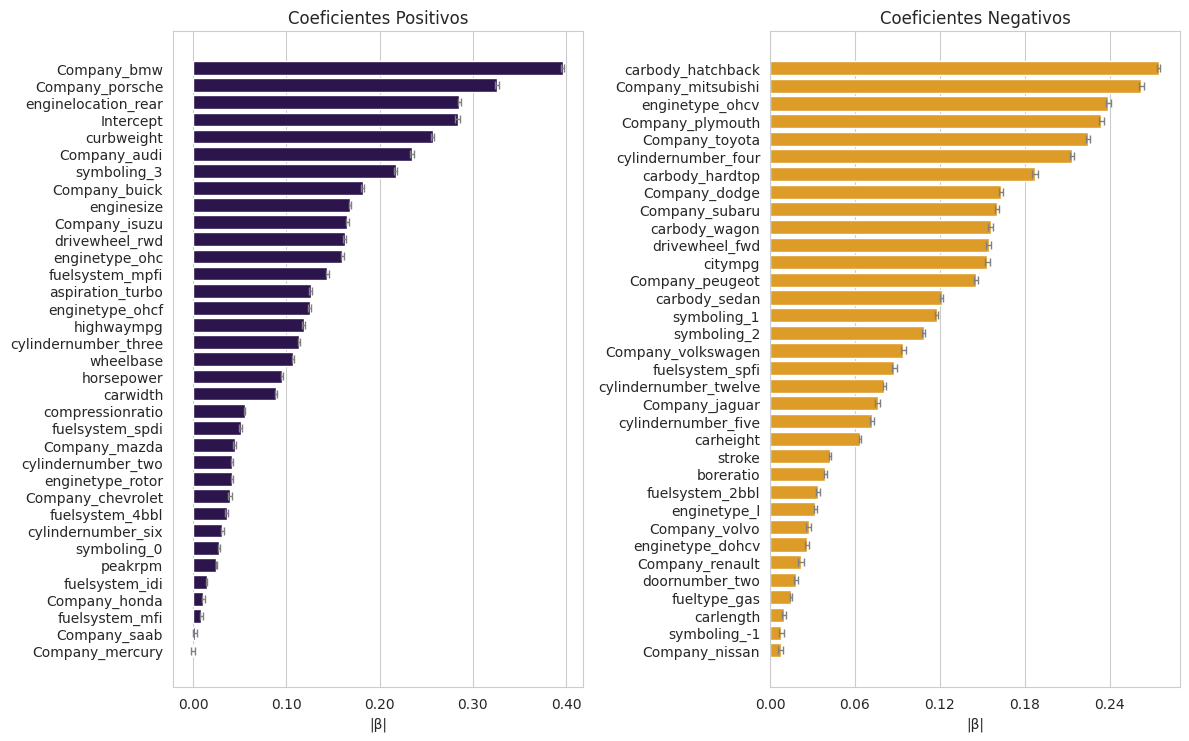

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker



# 1) Criar sinal, importância e erro padrão (a partir de variância)
beta_var_ridge['sinal'] = beta_var_ridge['beta'].apply(lambda x: 'POS' if x >= 0 else 'NEG')
beta_var_ridge['importancia'] = beta_var_ridge['beta'].abs()
beta_var_ridge['erro'] = np.sqrt(beta_var_ridge['variance'])

# 2) Separar em dois DataFrames: positivos e negativos
df_pos = beta_var_ridge[beta_var_ridge['beta'] >= 0].copy().sort_values('importancia', ascending=False)
df_neg = beta_var_ridge[beta_var_ridge['beta'] <  0].copy().sort_values('importancia', ascending=False)

# 3) Resetar índice para transformar nome da variável em coluna
df_pos = df_pos.reset_index().rename(columns={'index': 'variavel'})
df_neg = df_neg.reset_index().rename(columns={'index': 'variavel'})

# 4) Criar figura com 2 subplots lado a lado
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8), sharey=False)
sns.set_style("whitegrid")

# — Gráfico para BETAS POSITIVOS (lado esquerdo)
sns.barplot(
    data=df_pos,
    y='variavel',
    x='importancia',
    palette={'POS': '#2B0A56'},
    hue='sinal',
    dodge=False,
    ax=ax1,
    errorbar=None
)
for i, (beta, erro) in enumerate(zip(df_pos['beta'], df_pos['erro'])):
    ax1.errorbar(
        x=abs(beta), y=i,
        xerr=erro,
        fmt='none',
        ecolor='gray',
        capsize=3,
        linewidth=1
    )
ax1.set_title('Coeficientes Positivos')
ax1.set_xlabel('|β|')
ax1.set_ylabel('')  # removido o rótulo “Variável” aqui

# Ajustar ticks do eixo X do ax1
ax1.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
ax1.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Remover legenda redundante
ax1.legend([], [], frameon=False)


# — Gráfico para BETAS NEGATIVOS (lado direito)
sns.barplot(
    data=df_neg,
    y='variavel',
    x='importancia',
    palette={'NEG': '#fba40a'},
    hue='sinal',
    dodge=False,
    ax=ax2,
    errorbar=None
)
for i, (beta, erro) in enumerate(zip(df_neg['beta'], df_neg['erro'])):
    ax2.errorbar(
        x=abs(beta), y=i,
        xerr=erro,
        fmt='none',
        ecolor='gray',
        capsize=3,
        linewidth=1
    )
ax2.set_title('Coeficientes Negativos')
ax2.set_xlabel('|β|')
ax2.set_ylabel('')  # já estava sem rótulo

# Ajustar ticks do eixo X do ax2 (opcional, mas para manter padrão de casas decimais)
ax2.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
ax2.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Remover legenda redundante
ax2.legend([], [], frameon=False)


#plt.suptitle('Ridge: Importância das variáveis (Positivos à esquerda, Negativos à direita)', y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('importancia_betas.pdf', format='pdf', dpi=300)
plt.show()


In [ ]:
import math
num_colunas = len(betas_ridge[0])
num_graficos = 12
tamanho_bloco = math.ceil(num_colunas / num_graficos)

for g in range(num_graficos):
    inicio = g * tamanho_bloco
    fim = min((g + 1) * tamanho_bloco, num_colunas)

    plt.figure(figsize=(8, 4))

    for i in range(inicio, fim):
        plt.plot(alphas, [beta[i] for beta in betas_ridge], label=nomes_colunas[i])

    plt.legend(fontsize='x-small', loc='upper right')
    plt.title(f'Gráfico {g + 1} ({fim - inicio} curvas)')
    plt.xlabel('Alphas')
    plt.ylabel('Coeficientes')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


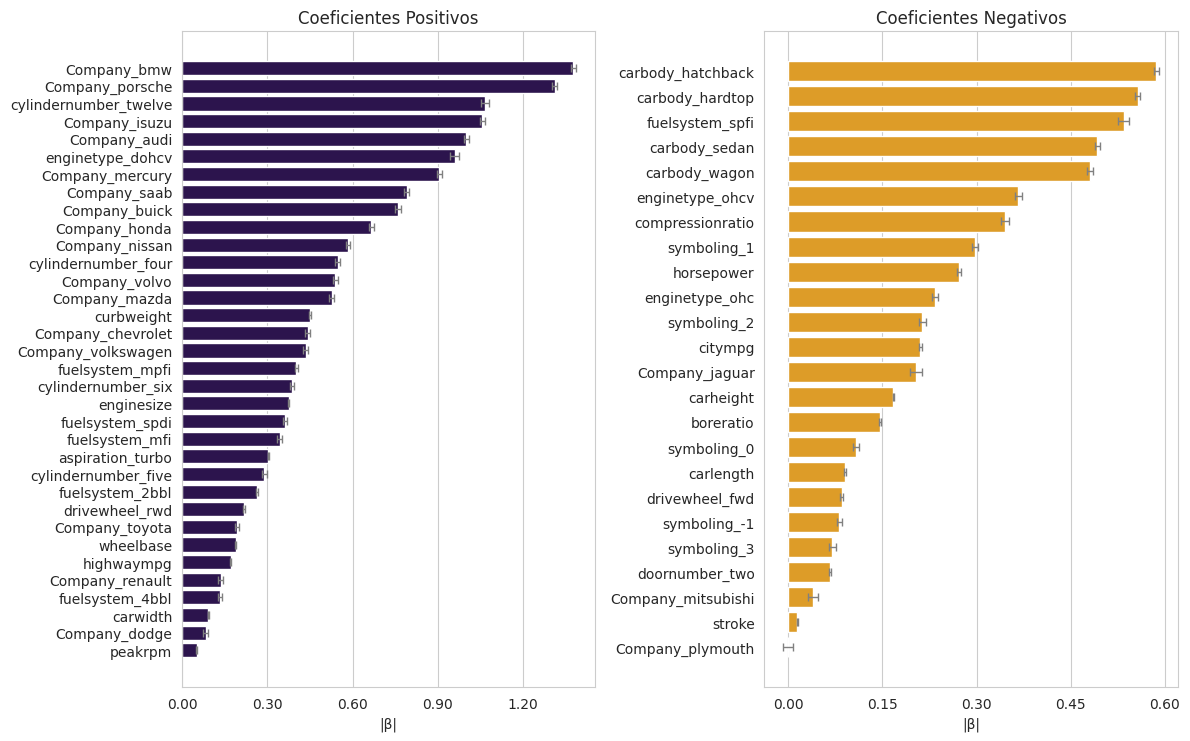

In [ ]:
#import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker



# 1) Criar sinal, importância e erro padrão (a partir de variância)
beta_var_mmq_pi['sinal'] = beta_var_mmq_pi['beta'].apply(lambda x: 'POS' if x >= 0 else 'NEG')
beta_var_mmq_pi['importancia'] = beta_var_mmq_pi['beta'].abs()
beta_var_mmq_pi['erro'] = np.sqrt(beta_var_mmq_pi['variance'])

excluidas = beta_var_mmq_pi[np.abs(beta_var_mmq_pi['variance'])>1].copy()
beta_var_mmq_pi = beta_var_mmq_pi[np.abs(beta_var_mmq_pi['erro'])<1]


# 2) Separar em dois DataFrames: positivos e negativos
df_pos = beta_var_mmq_pi[beta_var_mmq_pi['beta'] >= 0].copy().sort_values('importancia', ascending=False)
df_neg = beta_var_mmq_pi[beta_var_mmq_pi['beta'] <  0].copy().sort_values('importancia', ascending=False)

# 3) Resetar índice para transformar nome da variável em coluna
df_pos = df_pos.reset_index().rename(columns={'index': 'variavel'})
df_neg = df_neg.reset_index().rename(columns={'index': 'variavel'})

# 4) Criar figura com 2 subplots lado a lado
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8), sharey=False)
sns.set_style("whitegrid")

# — Gráfico para BETAS POSITIVOS (lado esquerdo)
sns.barplot(
    data=df_pos,
    y='variavel',
    x='importancia',
    palette={'POS': '#2B0A56'},
    hue='sinal',
    dodge=False,
    ax=ax1,
    errorbar=None
)

for i, (beta, erro) in enumerate(zip(df_pos['beta'], df_pos['erro'])):
    ax1.errorbar(
        x=abs(beta), y=i,
        xerr=erro,
        fmt='none',
        ecolor='gray',
        capsize=3,
        linewidth=1
    )

ax1.set_title('Coeficientes Positivos')
ax1.set_xlabel('|β|')
ax1.set_ylabel('')  # removido o rótulo “Variável” aqui

# Ajustar ticks do eixo X do ax1
ax1.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
ax1.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Remover legenda redundante
ax1.legend([], [], frameon=False)


# — Gráfico para BETAS NEGATIVOS (lado direito)
sns.barplot(
    data=df_neg,
    y='variavel',
    x='importancia',
    palette={'NEG': '#fba40a'},
    hue='sinal',
    dodge=False,
    ax=ax2,
    errorbar=None
)

for i, (beta, erro) in enumerate(zip(df_neg['beta'], df_neg['erro'])):
    ax2.errorbar(
        x=abs(beta), y=i,
        xerr=erro,
        fmt='none',
        ecolor='gray',
        capsize=3,
        linewidth=1
    )

ax2.set_title('Coeficientes Negativos')
ax2.set_xlabel('|β|')
ax2.set_ylabel('')  # já estava sem rótulo

# Ajustar ticks do eixo X do ax2 (opcional, mas para manter padrão de casas decimais)
ax2.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
ax2.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Remover legenda redundante
ax2.legend([], [], frameon=False)


#plt.suptitle('Ridge: Importância das variáveis (Positivos à esquerda, Negativos à direita)', y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('betas_mmq_pi.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
excluidas

,index,beta,variance,sinal,importancia,erro
9,fuelsystem_idi,0.717147,-1.645409e+07,POS,0.717147,NaN
11,cylindernumber_three,0.626544,-5.065949e+07,POS,0.626544,NaN
16,enginetype_rotor,0.504211,-7.051396e+07,POS,0.504211,NaN
17,cylindernumber_two,0.477504,-7.051396e+07,POS,0.477504,NaN
18,enginelocation_rear,0.457374,4.664966e+07,POS,0.457374,6830.055774
26,enginetype_ohcf,0.344165,4.664966e+07,POS,0.344165,6830.055774
32,enginetype_l,0.200104,-5.065949e+07,POS,0.200104,NaN
41,Intercept,0.036588,-1.645409e+07,POS,0.036588,NaN
53,Company_subaru,-0.188410,4.664966e+07,NEG,0.188410,6830.055774
62,Company_peugeot,-0.472171,-5.065949e+07,NEG,0.472171,NaN


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


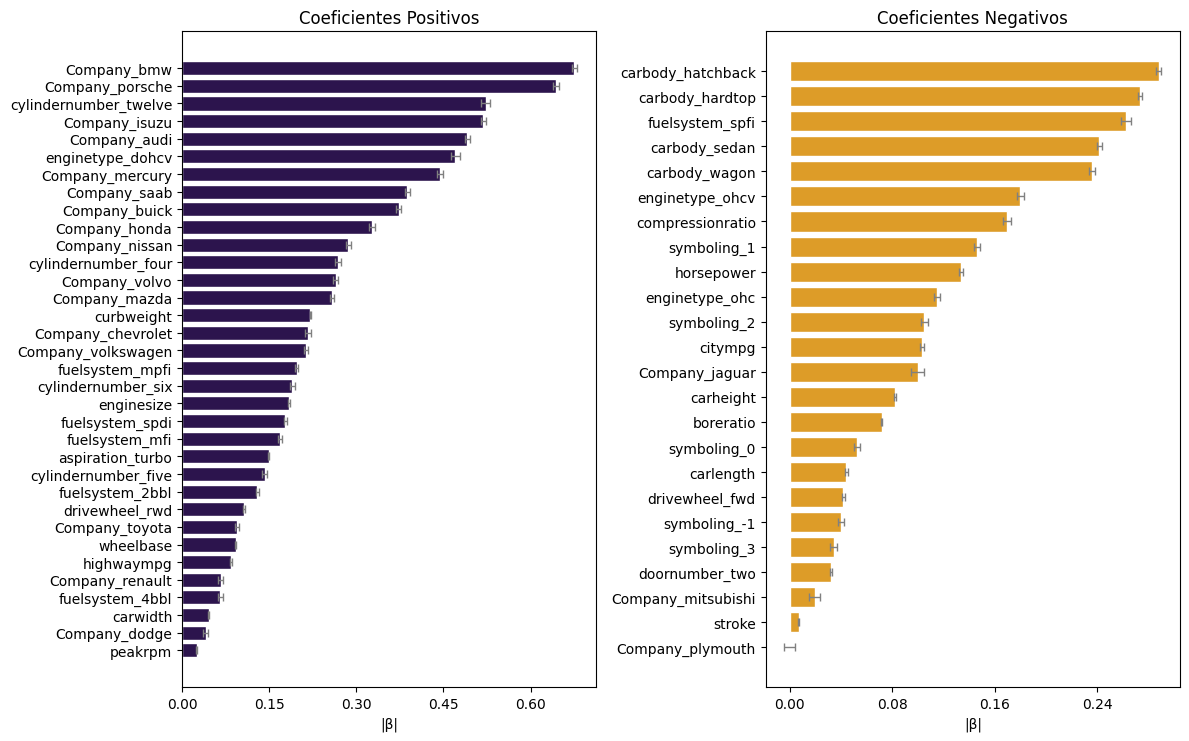

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker

# — Exemplo de DataFrame (substitua pelo seu beta_var de verdade):
# beta_var = pd.DataFrame({
#     'beta': [0.5, -0.3, 0.8, -0.1, 0.2],
#     'variancia': [0.04, 0.01, 0.09, 0.025, 0.016]
# }, index=['var_a', 'var_b', 'var_c', 'var_d', 'var_e'])

# 1) Criar sinal, importância e erro padrão (a partir de variância)
beta_var_manual['sinal'] = beta_var_manual['beta'].apply(lambda x: 'POS' if x >= 0 else 'NEG')
beta_var_manual['importancia'] = beta_var_manual['beta'].abs()
beta_var_manual['erro'] = np.sqrt(beta_var_manual['variance'])

excluidas = beta_var_manual[np.abs(beta_var_manual['variance'])>100].copy()
beta_var_manual = beta_var_manual[np.abs(beta_var_manual['variance'])<100]


# 2) Separar em dois DataFrames: positivos e negativos
df_pos = beta_var_manual[beta_var_manual['beta'] >= 0].copy().sort_values('importancia', ascending=False)
df_neg = beta_var_manual[beta_var_manual['beta'] <  0].copy().sort_values('importancia', ascending=False)

# 3) Resetar índice para transformar nome da variável em coluna
df_pos = df_pos.reset_index().rename(columns={'index': 'variavel'})
df_neg = df_neg.reset_index().rename(columns={'index': 'variavel'})

# 4) Criar figura com 2 subplots lado a lado
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 8), sharey=False)
sns.set_style("whitegrid")

# — Gráfico para BETAS POSITIVOS (lado esquerdo)
sns.barplot(
    data=df_pos,
    y='variavel',
    x='importancia',
    palette={'POS': '#2B0A56'},
    hue='sinal',
    dodge=False,
    ax=ax1,
    errorbar=None
)

for i, (beta, erro) in enumerate(zip(df_pos['beta'], df_pos['erro'])):
    ax1.errorbar(
        x=abs(beta), y=i,
        xerr=erro,
        fmt='none',
        ecolor='gray',
        capsize=3,
        linewidth=1
    )

ax1.set_title('Coeficientes Positivos')
ax1.set_xlabel('|β|')
ax1.set_ylabel('')  # removido o rótulo “Variável” aqui

# Ajustar ticks do eixo X do ax1
ax1.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
ax1.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Remover legenda redundante
ax1.legend([], [], frameon=False)


# — Gráfico para BETAS NEGATIVOS (lado direito)
sns.barplot(
    data=df_neg,
    y='variavel',
    x='importancia',
    palette={'NEG': '#fba40a'},
    hue='sinal',
    dodge=False,
    ax=ax2,
    errorbar=None
)

for i, (beta, erro) in enumerate(zip(df_neg['beta'], df_neg['erro'])):
    ax2.errorbar(
        x=abs(beta), y=i,
        xerr=erro,
        fmt='none',
        ecolor='gray',
        capsize=3,
        linewidth=1
    )

ax2.set_title('Coeficientes Negativos')
ax2.set_xlabel('|β|')
ax2.set_ylabel('')  # já estava sem rótulo

# Ajustar ticks do eixo X do ax2 (opcional, mas para manter padrão de casas decimais)
ax2.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))
ax2.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Remover legenda redundante
ax2.legend([], [], frameon=False)


#plt.suptitle('Ridge: Importância das variáveis (Positivos à esquerda, Negativos à direita)', y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('betas_mmq.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
excluidas[['beta','variance']]

,beta,variance
Intercept,2.188477e+02,-2.341944e+15
fueltype_gas,-2.168945e+02,-2.341944e+15
Company_peugeot,-1.659763e+02,-1.259326e+15
Company_subaru,-8.610021e+14,1.940320e+15
enginelocation_rear,-8.610021e+14,2.040228e+15
enginetype_l,1.813809e+02,-1.259326e+15
enginetype_ohcf,8.610021e+14,1.965615e+15
enginetype_rotor,-1.019575e+02,-5.148233e+18
cylindernumber_three,1.087429e+01,-1.259326e+15
cylindernumber_two,1.017298e+02,-5.148233e+18


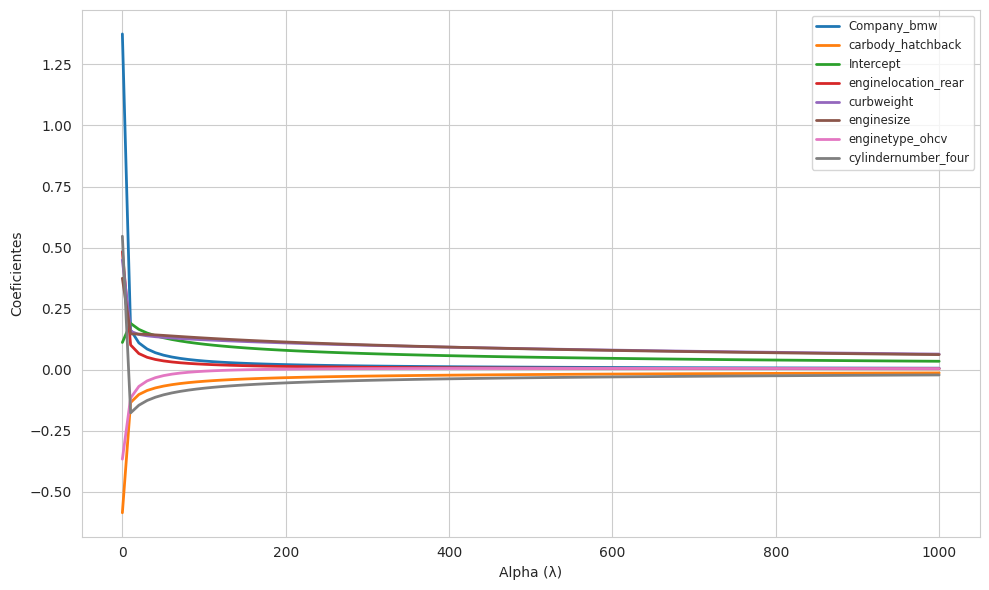

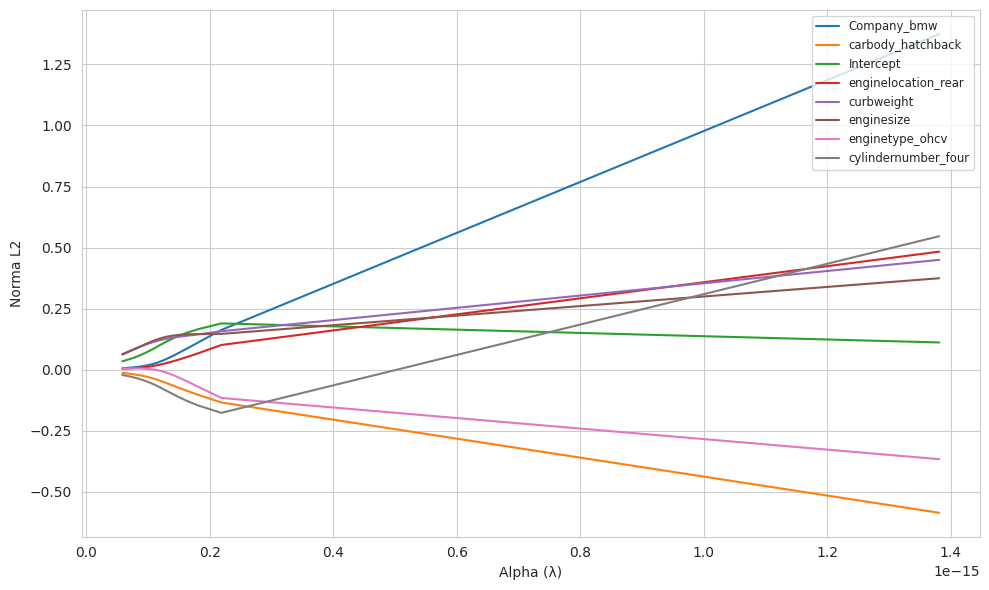

In [ ]:
'''
for i in beta_mmq:
  mmq_norm =  np.linalg.norm(i)
'''
mmq_norm =  np.linalg.norm(beta_mmq)
l2_norm = []

#l2_norm = [np.linalg.norm(betas_ridge) / np.linalg.norm(beta_mmq) for beta in betas_ridge]

for i in betas_ridge:
  l2_norm.append(np.linalg.norm(i))

l2_norm = l2_norm / mmq_norm
# Lista com os nomes das 6 colunas que você quer exibir
colunas_desejadas = ['Company_bmw', 'carbody_hatchback' ,'Intercept','enginelocation_rear', 'curbweight', 'enginesize', 'enginetype_ohcv','cylindernumber_four']
#colunas_desejadas = ['carbody_hatchback' ,'Intercept','enginelocation_rear']



# Encontra os índices dessas colunas na lista nomes_colunas
indices_desejados = [list(nomes_colunas).index(nome) for nome in colunas_desejadas]
plt.figure(figsize=(10, 6))


for i in indices_desejados:
    plt.plot(alphas, [beta[i] for beta in betas_ridge], label=nomes_colunas[i],lw = 2)

plt.legend(fontsize='small', loc='upper right')
plt.xlabel('Alpha (λ)')
plt.ylabel('Coeficientes')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
# Iterate using the index of indices_desejados to access colunas_desejadas
for idx, i in enumerate(indices_desejados):
    plt.plot(l2_norm, [beta[i] for beta in betas_ridge], label = colunas_desejadas[idx])
plt.legend(fontsize='small', loc='upper right')
plt.xlabel('Alpha (λ)')
plt.ylabel('Norma L2')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-22-b4f51a090ffc>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('inferno', len(indices_desejados))


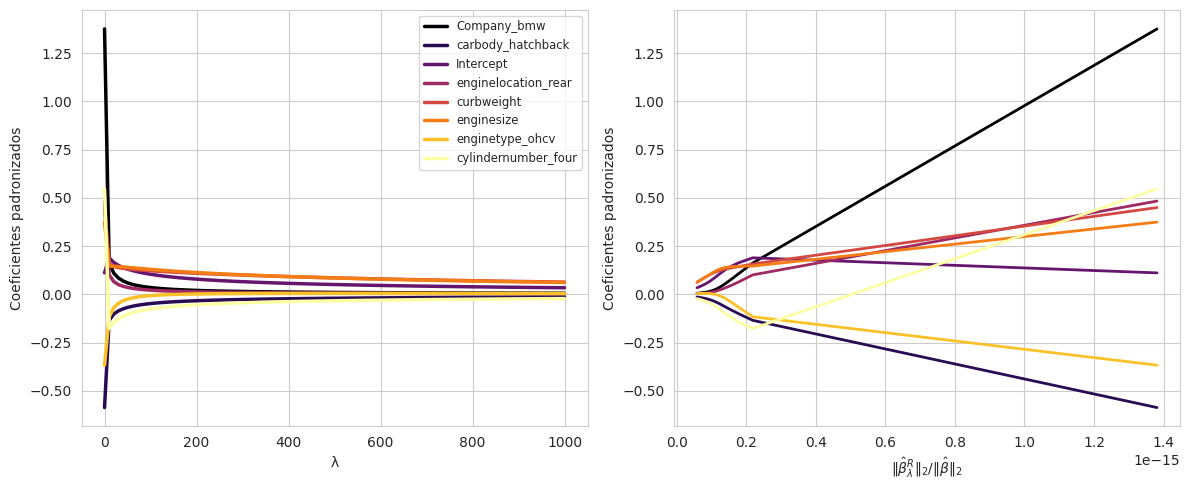

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Importar o módulo cm para colormaps

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 linha, 2 colunas

# Define o colormap que você quer usar e o número de cores que você precisa
colormap = cm.get_cmap('inferno', len(indices_desejados))
colors = [colormap(i) for i in range(len(indices_desejados))] # Obtém as cores da paleta

# Primeiro gráfico (coeficientes vs alpha)
for idx, i in enumerate(indices_desejados):
    # Atribui uma cor da paleta para cada linha
    axs[0].plot(alphas, [beta[i] for beta in betas_ridge], label=nomes_colunas[i], lw=2.5, color=colors[idx])

#axs[0].set_title('Coeficientes vs Alpha')
axs[0].set_xlabel('λ')
axs[0].set_ylabel('Coeficientes padronizados')
axs[0].grid(True)
axs[0].legend(fontsize='small', loc='upper right')

# Segundo gráfico (coeficientes vs norma L2)
for idx, i in enumerate(indices_desejados):
    # Você pode reutilizar as mesmas cores para o segundo gráfico se desejar
    axs[1].plot(l2_norm, [beta[i] for beta in betas_ridge], label=colunas_desejadas[idx], lw=2, color=colors[idx])
#axs[1].set_title('Coeficientes vs Norma L2')
axs[1].set_xlabel(r'$\|\hat{\beta}_\lambda^R\|_2 / \|\hat{\beta}\|_2$')
axs[1].set_ylabel('Coeficientes padronizados')
axs[1].grid(True)
#axs[1].legend(fontsize='small', loc='upper left')


plt.tight_layout()
fig.savefig('graficos_ridge.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
np.min(np.abs(res_manual_test))

2597.378174687933

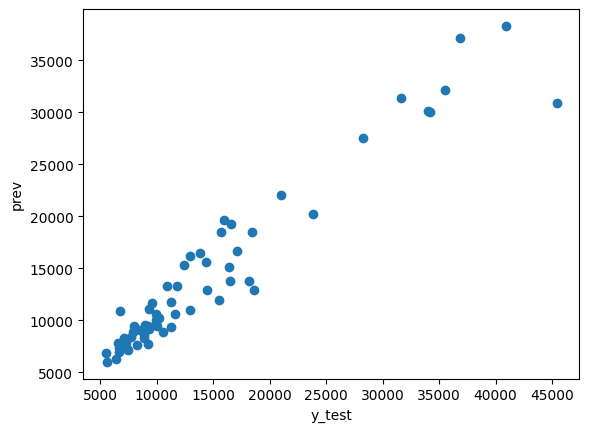

In [ ]:
plt.scatter(y_test, Y_prev)
plt.xlabel('y_test')
plt.ylabel('prev')
plt.show()

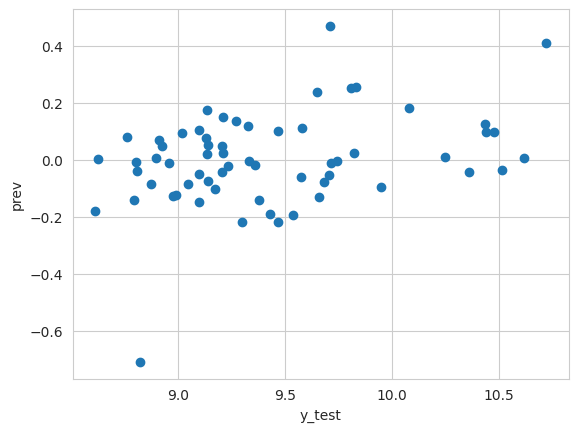

In [ ]:
plt.scatter(y_test, res_mmq)
plt.xlabel('y_test')
plt.ylabel('prev')
plt.show()


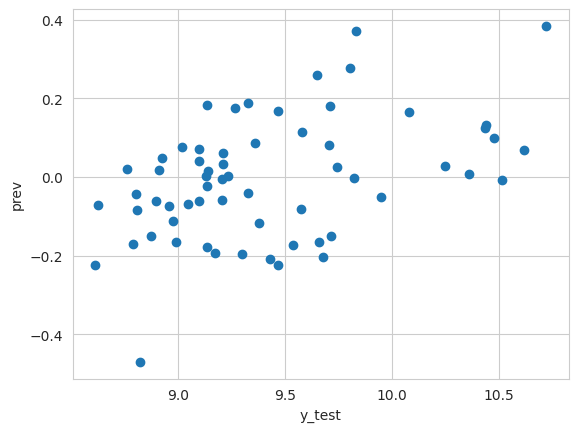

In [ ]:
plt.scatter(y_test,res)
plt.xlabel('y_test')
plt.ylabel('prev')
plt.show()

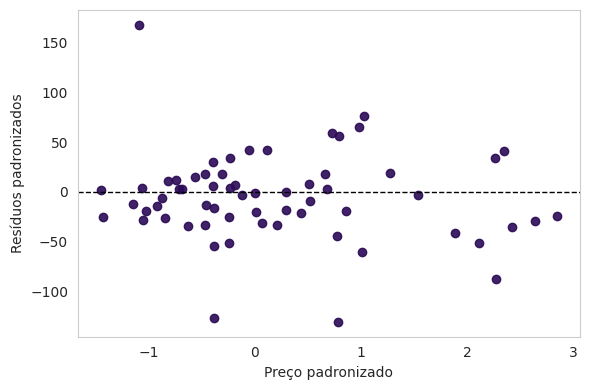

In [ ]:
'''
plt.scatter(y_test,res_manual_test)
plt.xlabel('y_test')
plt.ylabel('Resíduos()')
plt.show()
'''
plt.figure(figsize = (6,4))
plt.scatter(y_test, res_mmq_teste, alpha=0.9, color = '#2B0A56')
plt.gca().grid(False)
plt.xlabel("Preço padronizado")
plt.ylabel(r"Resíduos padronizados")
plt.axhline(0, color="k", lw=1, ls="--")
plt.tight_layout()
plt.savefig('res_mmq_manual.pdf', format='pdf', dpi=300)

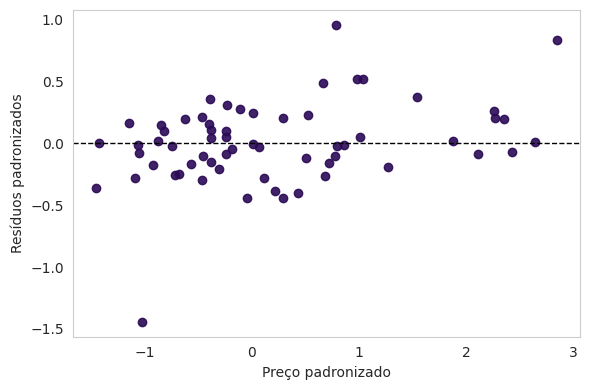

In [ ]:
plt.figure(figsize = (6,4))
plt.scatter(y_test, res_mmq_pi_teste, alpha=0.9, color = '#2B0A56')
plt.gca().grid(False)
plt.xlabel("Preço padronizado")
plt.ylabel(r"Resíduos padronizados")
plt.axhline(0, color="k", lw=1, ls="--")
plt.tight_layout()
plt.savefig('res_mmq_pi.pdf', format='pdf', dpi=300)

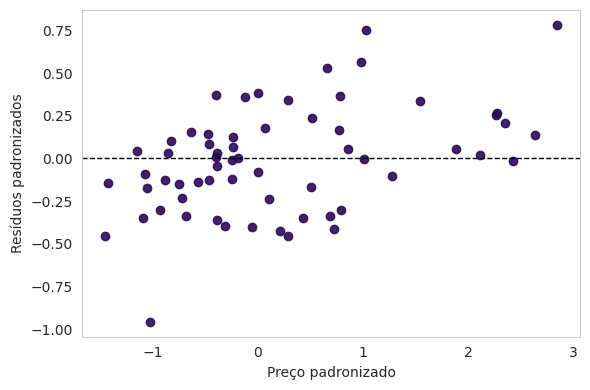

In [ ]:
plt.figure(figsize = (6,4))
plt.scatter(y_test, res_teste, alpha=0.9, color = '#2B0A56')
plt.gca().grid(False)
plt.xlabel("Preço padronizado")
plt.ylabel(r"Resíduos padronizados")
plt.axhline(0, color="k", lw=1, ls="--")
plt.tight_layout()
plt.savefig('res_teste.pdf', format='pdf', dpi=300)

,beta,variance
Intercept,0.000000,0.000020
wheelbase,0.071247,0.000007
carlength,-0.055711,0.000008
carwidth,0.081380,0.000006
carheight,-0.003917,0.000003
...,...,...
fuelsystem_idi,0.027409,0.000003
fuelsystem_mfi,0.000000,0.000000
fuelsystem_mpfi,0.069502,0.000007
fuelsystem_spdi,0.010470,0.000013
